# Input pipeline - Preprocessing

In this notebook we will discuss the necessary steps, algorithms, and techniques applied to the data to get it ready to feed our Ml custom model, it will cover:

1.  Splitting the data into 'train', 'test' and validation sets
2.  Dealing with the 'unknown' and silence labels
3.  Reading the audio files
4.  Preprocessing the data, data augmentation
5.  Saving and compressing the audio files, creating a TFRecords dataset

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import IPython.display as ipd
import re
import hashlib
from tensorflow.python.util import compat
import tensorflow as tf
import numpy as np
from data_utils import TFRecordsConverter
#Input pipeline settings
from settings import *

# 1. Train, Test and validation split

Dataset split is done applying the function "which_set", which was provided by google alongside with the dataset, it takes as parameters the name of the file and the percentages of the testing and validation sets. Basically, a hash function is applied over the name of the files so it can be determined which split they should be assigned to.
A full description of how the procces is done can be found in the function's docs

In [2]:
# Split function provided by Google
def which_set(filename, validation_percentage, testing_percentage):
      """Determines which data partition the file should belong to.
      We want to keep files in the same training, validation, or testing sets even
      if new ones are added over time. This makes it less likely that testing
      samples will accidentally be reused in training when long runs are restarted
      for example. To keep this stability, a hash of the filename is taken and used
      to determine which set it should belong to. This determination only depends on
      the name and the set proportions, so it won't change as other files are added.

      It's also useful to associate particular files as related (for example words
      spoken by the same person), so anything after '_nohash_' in a filename is
      ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
      'bobby_nohash_1.wav' are always in the same set, for example.

      Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.

      Returns:
        String, one of 'training', 'validation', or 'testing'.
      """
      MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M
      base_name = os.path.basename(filename)
      # We want to ignore anything after '_nohash_' in the file name when
      # deciding which set to put a wav in, so the data set creator has a way of
      # grouping wavs that are close variations of each other.
      hash_name = re.sub(r'_nohash_.*$', '', base_name)
      # This looks a bit magical, but we need to decide whether this file should
      # go into the training, testing, or validation sets, and we want to keep
      # existing files in the same set even if more files are subsequently
      # added.
      # To do that, we need a stable way of deciding based on just the file name
      # itself, so we do a hash of that and then use that to generate a
      # probability value that we use to assign it.
      hash_name_hashed = hashlib.sha1(compat.as_bytes(hash_name)).hexdigest()
      percentage_hash = ((int(hash_name_hashed, 16) %
                          (MAX_NUM_WAVS_PER_CLASS + 1)) *
                         (100.0 / MAX_NUM_WAVS_PER_CLASS))
      if percentage_hash < validation_percentage:
        result = 'validation'
      elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
      else:
        result = 'training'
      return result

Let's test the function over the first audio file:

In [17]:
data_path = 'data/raw_data'
# Choose one audio clip to work with
audio_filename = os.path.join(data_path, 'bed', '00176480_nohash_0.wav')

# Splits 10% for testing, 10% for validation and 80% for training. 
validation_percentage = 10
testing_percentage = 10

split_set = which_set(audio_filename, validation_percentage, testing_percentage)
print(f'{audio_filename} belongs to the "{split_set}" set')

data/raw_data/bed/00176480_nohash_0.wav belongs to the "training" set


# 2. Dealing with the "Unknown" and "Silence" data
As we could see in the "Data Exploration" notebook we don't have an explicit set of audio files labeled as Unknown or Silence, so we need to find a way to asign to some of the data these labels. This process will go as follows:

- Silence data will be prepared with 1 second files filled with "0" 
- We will label as "Unknown" any audio file that doesn't belongs to the words we want to predict, so for example, all files under the "bed" label will be relabeled as "Unknown"

All these steps were implemented and wraped in other handy function provided by Google prepare_data_index(). This function was integrated to our master input pipeline Class "TFRecordsConverter". The next cell shows a glance of the result.

In [3]:
#Creating the converter..
#Lets ignore for the moment the parameters to init the coverter as 
#they will have more sence later 
converter = TFRecordsConverter(RAW_DATA_DIR,
                                OUTPUT_DIR,
                                SILENT_SIZE,
                                UNKNOW_SIZE,
                                TRAIN_WORDS,
                                VAL_SIZE,
                                TEST_SIZE,
                                NUM_SHARDS_VAL,
                                NUM_SHARDS_TEST,
                                NUM_SHARDS_TRAIN)
#Focus on this...
#When the converter is created the prepare_data_index() function is executed
#This is the output


['_silence_',
 '_unknown_',
 'yes',
 'no',
 'up',
 'down',
 'left',
 'right',
 'on',
 'off',
 'stop',
 'go']

In [11]:
converter.data_index['testing'][:10]

[{'label': 'left', 'file': 'data/raw_data/left/5f814c23_nohash_0.wav'},
 {'label': '_silence_', 'file': 'data/raw_data/down/00176480_nohash_0.wav'},
 {'label': 'on', 'file': 'data/raw_data/on/9a7c1f83_nohash_3.wav'},
 {'label': 'go', 'file': 'data/raw_data/go/ca48dc76_nohash_0.wav'},
 {'label': 'on', 'file': 'data/raw_data/on/5c8af87a_nohash_0.wav'},
 {'label': 'off', 'file': 'data/raw_data/off/81dc4a94_nohash_0.wav'},
 {'label': '_silence_', 'file': 'data/raw_data/down/00176480_nohash_0.wav'},
 {'label': 'stop', 'file': 'data/raw_data/stop/9a7c1f83_nohash_1.wav'},
 {'label': 'up', 'file': 'data/raw_data/up/9a7c1f83_nohash_3.wav'},
 {'label': 'go', 'file': 'data/raw_data/go/97f4c236_nohash_1.wav'}]

# 3. Reading the audio files
Now that we have the data splited the next step in the input pipeline is to read and load the audio files. Mostly, we will use TensorFlow functions to manipulate and apply any transformation to the data, as most of these funtions are implemented with TPU/GPU-compatible ops and supports gradients.

In [ ]:
data_path = 'data/raw_data'
# Choose one audio clip to work with
bed_audio = os.path.join(data_path, 'bed', '00176480_nohash_0.wav')

In [ ]:
#readind the audio file...
raw_audio = tf.io.read_file(bed_audio)
# Let's check what we've got
print(f'raw_audio {type(raw_audio)}')   
print(f'raw_audio {raw_audio.numpy()[:20]}') # Print the head(20) of the raw audio


Two things to take from this output:

- raw_audio is indeed a TensorFlow Tensor, any further function or transformation will be handled as a Tensor's operation
- raw_audio data is a binary file, so we need to decode it

In [ ]:
# Decoding...
# We will use another handy tf function: audio.decode_wav...
# https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav

# All audio files were recorded at 16000 samples / seconds
sample_rate = 16000	
audio, sample_rate = tf.audio.decode_wav(raw_audio,
                                         desired_channels=1,  # mono
                                         desired_samples=sample_rate )
                                         
print(f'audio {type(audio)}')   
print(f'audio {audio.shape}') 
print(f'audio {audio.numpy()[:10]}') # Print the head(10) of the decoded audio

In [ ]:
# Let's plot the audio signal wave (just the 500 first samples)
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(audio.numpy()[:500])
plt.title('Audio signal wave')
plt.xlabel('Samples 16000/s')
plt.ylabel('Signal amplitude')
plt.show()

# 3. Data augmentation


We will apply the following transformations to our raw audio files:
- Time shiffting
- Background mixing

# Time Shifting

What we will do here is shift the audio signal a fraction of a second, the aim is to create randomly shifted audios to help the model cope with the differences in time the words were recorded.


In [37]:
# Time shifting
def audio_shift(audio, time_shift_ms, sample_rate):
    """Randomly shift an audio signal

    Args:
    audio: audio to shift.
    time_shift_ms: value in ms to shift, it could be negative in that case 
    shiffting will be applied to the left.
    sample_rate: sample rate of the audio.

    Returns:
    The audio shifted.
    """
    # Time shift from ms to # samples
    time_shift = int((time_shift_ms * sample_rate) / 1000)
    audio_shifted = tf.roll(audio, time_shift, axis=0)

    return audio_shifted

In [25]:
data_path = 'data/raw_data'
# Choose one audio clip to work with
bed_audio = os.path.join(data_path, 'bed', '00176480_nohash_0.wav')

#readind the audio file...
raw_audio = tf.io.read_file(bed_audio)

sample_rate = 16000	
audio, sample_rate = tf.audio.decode_wav(raw_audio,
                                         desired_channels=1,  # mono
                                         desired_samples=sample_rate )

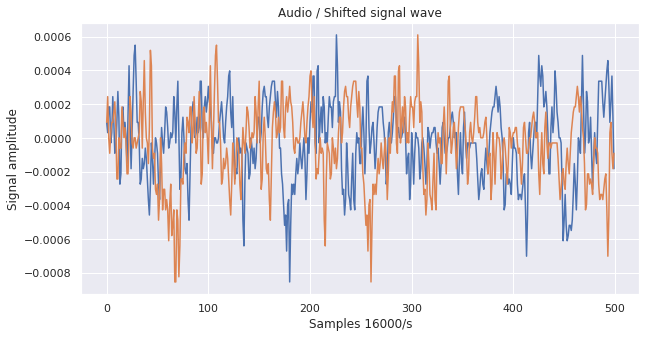

In [45]:
audio_shifted = audio_shift(audio, time_shift_ms=5, sample_rate=16000)

# Let's plot the audio together with the shifted audio(just the 500 first samples)
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(audio.numpy()[:500]) # Original blue line
plt.plot(audio_shifted.numpy()[:500]) # shifted orange line
plt.title('Audio / Shifted signal wave')
plt.xlabel('Samples 16000/s')
plt.ylabel('Signal amplitude')
plt.show()

# Backgoround Noise Mixing

Here, background noise is added to the original audio. The noise audios are taken from the _background_audio folder provided within the dataset, as these audios usually are longer than 1 second, random sections are taken and added with a volume rate between 0 and 0.2 of the original audio. The next function does what was described

In [64]:
# Add background noise
def mix_background_noise(audio, background_audio, background_volume, sample_rate):
    #As the background files are larger than 1 second
    #let's get a random windows of 1 second 
    background_offset = np.random.randint(0, len(background_audio) - sample_rate)
    background_clipped = background_audio[background_offset:(background_offset + sample_rate)]
    background_reshaped = tf.reshape(background_clipped, [sample_rate, 1])
    #Set the background volume
    background_audio = background_volume * background_reshaped
    #mix the audio with the background
    mixed_audio = audio + background_audio
    return mixed_audio

In [65]:
#Choose one background audio clip to work with
background_audio_filename = os.path.join(data_path, '_background_noise_', 'doing_the_dishes.wav')

#Readind the audio file...
background_audio = tf.io.read_file(background_audio_filename)

background_audio, sample_rate = tf.audio.decode_wav(background_audio, desired_channels=1)

mixed_audio = mix_background_noise(audio, background_audio, background_volume=0.2, sample_rate=16000)

In [66]:
#Playing normal audio
ipd.Audio(audio.numpy(), rate=16000)

In [67]:
#Playing mixed audio
ipd.Audio(mixed_audio.numpy(), rate=16000)

When applying these function to the dataset we will assign some parameters randomly, like the milliseconds to shift, the volume of the background noise and the percentage of audio files that we will apply these transformations.

# 4. Converting and saving the files as a TFReords dataset

What is a TFRecord Datset?

TFRecord is a format to store serialized data and store it in a set of files (100-200MB each) so it can be read efficiently. Instead of reading file by file (each audio file separately) we can read the data linearly as a stream.

https://www.tensorflow.org/tutorials/load_data/tfrecord

To performe this convertion a "TFRecordsConverter" Class was created, it wrap all the code and necessary functions to execute the preprocessing steps previusly discussed:

    1. Data is splitted on 'train', 'test' and validationd sets
    2. Labels for special categories "Uknown" and "Silent" are asigned 
    3. Preprocessing functions are applied:
        - Time shift
        - Background noise mix
    4. Audio data and labels are packed and converted into TFRecords shunks and finally saved in the path "data/tfrecords"


In [69]:
_BASE_DIR = 'data/'

RAW_DATA_DIR = os.path.join(_BASE_DIR, 'raw_data')#Raw audio files directory
OUTPUT_DIR = os.path.join(_BASE_DIR, 'tfrecords') #Where to store the TFRecord data
SILENT_SIZE = 5  #Percentage of the silent category
UNKNOW_SIZE = 11 #Percentage of the Unknown category
# Words we want the system to recognize
TRAIN_WORDS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] 
VAL_SIZE = 10   #Percentage of the validation split
TEST_SIZE = 10  #Percentage of the test split
NUM_SHARDS_TRAIN = 16 #How many TFRecords files will contain all the training set
NUM_SHARDS_TEST = 2   #How many TFRecords files will contain all the testing set
NUM_SHARDS_VAL = 2    #How many TFRecords files will contain all the validation set

converter = TFRecordsConverter(RAW_DATA_DIR,
                                OUTPUT_DIR,
                                SILENT_SIZE,
                                UNKNOW_SIZE,
                                TRAIN_WORDS,
                                VAL_SIZE,
                                TEST_SIZE,
                                NUM_SHARDS_VAL,
                                NUM_SHARDS_TEST,
                                NUM_SHARDS_TRAIN)
converter.convert()

Converting validation set into TFRecord shards...
Converting testing set into TFRecord shards...
Converting training set into TFRecord shards...
Number of training examples: 21505
Number of testing examples: 2979
Number of validation examples: 2990
TFRecord files saved to data/tfrecords
